# Postprocess adjoint model output

In [1]:
import numpy as np
from matplotlib import pyplot as plt
#from matplotlib import cm, colors
#%matplotlib inline
import xgcm
import xmitgcm
#import cartopy as cart
#import cartopy.crs as ccrs
#import cartopy.feature as cf
import ecco_v4_py as ecco
import xarray as xr

from llcmap import *

## Load the grid

In [2]:
grid_dir = 'datasets/grids/llc90/'

In [3]:
ds = xmitgcm.open_mdsdataset(grid_dir,iters=None,geometry='llc')

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/xmitgcm/mds_store.py:837: UserWarning: Couldn't find available_diagnostics.log in datasets/grids/llc90/ or datasets/grids/llc90/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [4]:
# to use ecco_v4_py functions:
ds = ds.rename({'face':'tile'})

## Plot cell area

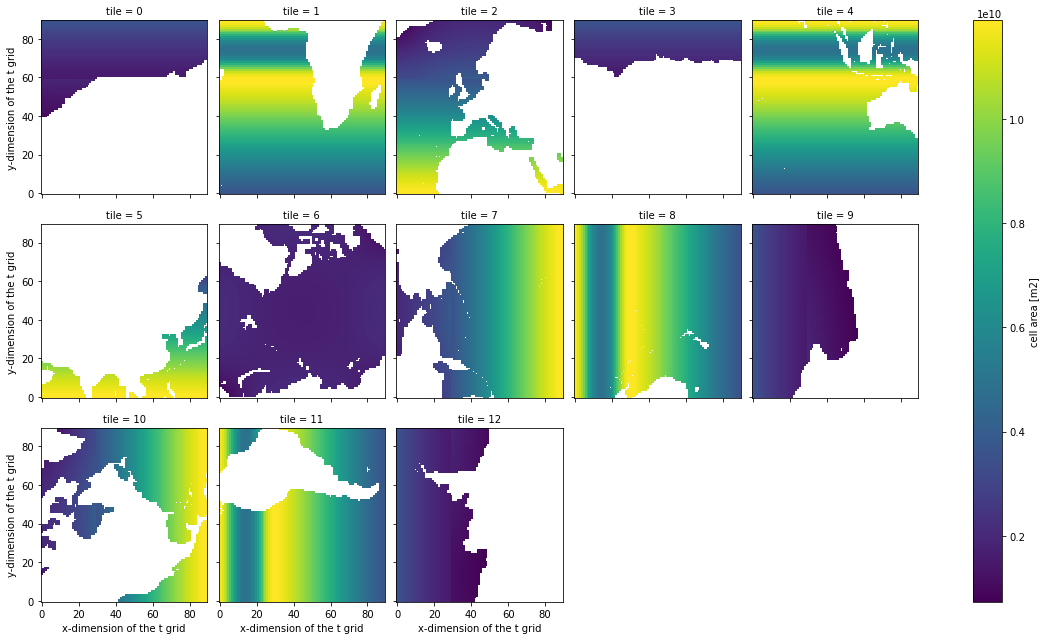

In [5]:
ds.rA.where(ds.maskC.isel(k=0)).plot(col='tile',col_wrap=5) #mask where land to avoid values area = 0
#ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,1*ds.maskC.isel(k=0))
#equivalently: ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,ds.maskC.isel(k=0).astype(float))

## Read sensitivities

In [6]:
def read_adxx(fdir,fname,nrecs):
    array = ecco.read_llc_to_tiles(fdir,fname,90,0,nrecs,less_output=True)
    return ecco.llc_tiles_to_xda(array,var_type='c',dim4='time') #'c': cell-centered sensitivities

In [7]:
ds.attrs = {'description': 'adjoint sensitivities computed from ECCOv4r3 1992-1996', 'author': 'Nora Loose'}
data_dir = '../mitgcm_analysis/OSNAP/'

In [8]:
exp_dir = 'runr3_boxmean_etaUK_coast_weekly_Mar1996'
exp = 'etaUK_coast'
fac = -1E-7
nrecs = 242 # get nrecs from corresponding xx_tauu/v.effective meta file

ds[exp + '_adxx_taux']= fac*read_adxx(data_dir+exp_dir+'/ADXXfiles',
                            fname='adxx_tauu.0000000059.data',nrecs=nrecs)/ds.rA.where(ds.maskC.isel(k=0))
ds[exp + '_adxx_tauy']= fac*read_adxx(data_dir+exp_dir+'/ADXXfiles',
                            fname='adxx_tauv.0000000059.data',nrecs=nrecs)/ds.rA.where(ds.maskC.isel(k=0))
    
ds[exp + '_adxx_taux'].attrs = {'units' : 'm/N', 
                                'description': 'Sensitivity of March UK sea level anomaly ' + 
                                                'to changes in zonal wind stress at decreasing lead times'}
ds[exp + '_adxx_tauy'].attrs = {'units' : 'm/N',
                                'description': 'Sensitivity of March UK sea level anomaly ' + 
                                                'to changes in meridional wind stress at decreasing lead times'}

In [9]:
# drop records with time index = 205 and higher, whose values are all 0 (since after evaluation of cost fct)
ds = ds.drop_sel(time=range(205,242))

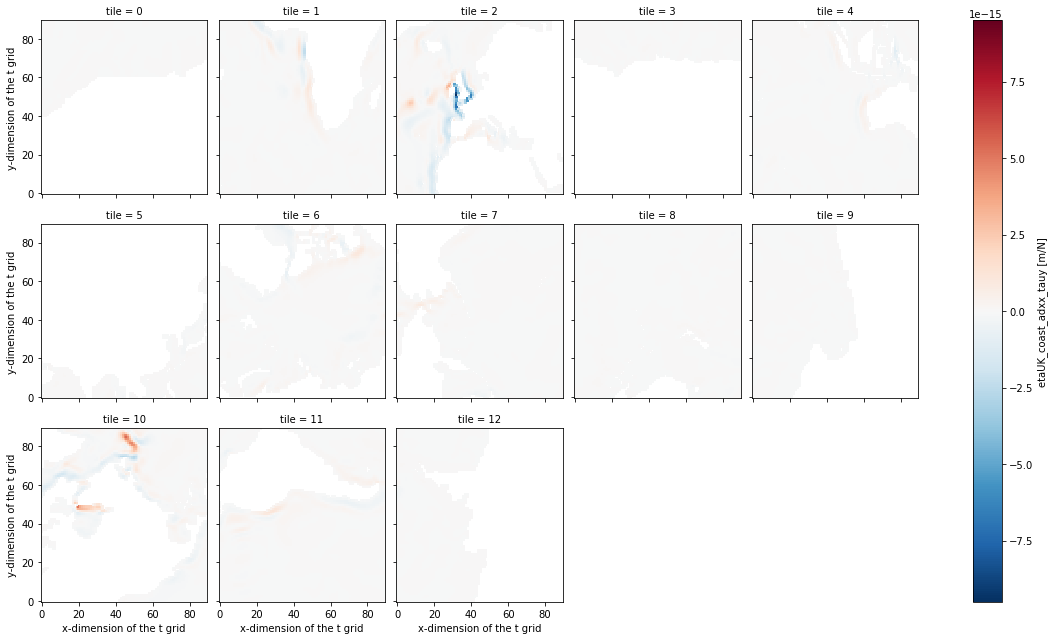

In [10]:
ds.etaUK_coast_adxx_tauy.isel(time=20).plot(col='tile',col_wrap=5)

In [11]:
mapper = atlantic_map(ds)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1026: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


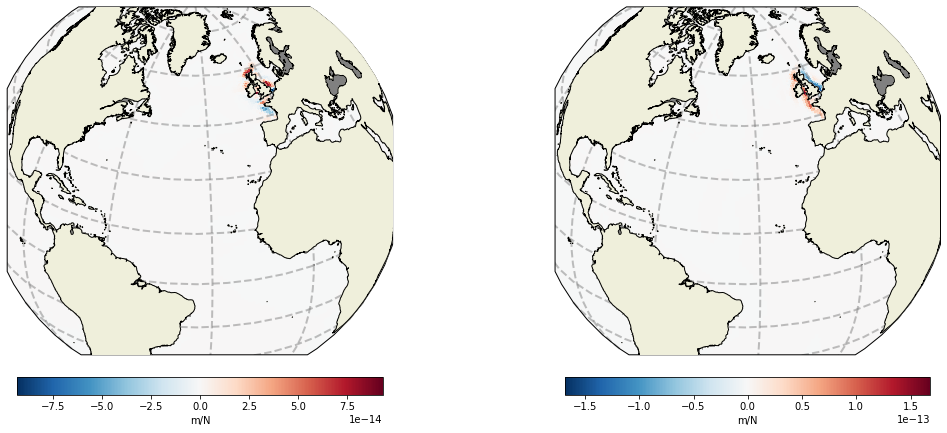

In [12]:
time = 204

fig,axs = plt.subplots(1,2,figsize=(18,8),
                      subplot_kw={'projection':ccrs.Orthographic(central_longitude=-35,central_latitude=30)})

mapper(ds[exp + '_adxx_taux'].isel(time=time), cmap='RdBu_r', 
        cbar_label= ds[exp + '_adxx_taux'].units, 
        ax=axs[0])
mapper(ds[exp + '_adxx_tauy'].isel(time=time),  cmap='RdBu_r',
       cbar_label= ds[exp + '_adxx_tauy'].units, 
       ax=axs[1])


In [13]:
from datetime import datetime, timedelta

In [14]:
my_iter_list = range(204,-1,-1)
my_iter_list

range(204, -1, -1)

In [15]:
#my_date_list = [datetime(year=2010,month=3,day=15,hour=12) - timedelta(days=30.5*x) for x in my_iter_list ]
my_date_list = [-timedelta(weeks=0.5+x) for x in my_iter_list ]

In [16]:
adj_time = np.array(my_date_list)

In [17]:
#ds2['adj_time'] = xr.DataArray(adj_time,coords={'time':ds2.time},dims=('time',))
ds['adj_time'] = xr.DataArray(adj_time,coords=ds.time.coords,dims=ds.time.dims)

In [18]:
ds = ds.set_coords('adj_time')
#ds = ds.swap_dims({'time':'adj_time'})
#ds2 = ds2.drop('time')

In [19]:
ds['adj_time'].attrs = {'description': 'Forcing lead time'}

## Write sensitivities on native grid to netcdf

In [20]:
ds.to_netcdf('datasets/monthlyEtaUK_weeklySens_native.nc')
# To open this: xarray.open_dataset(filename)

## Interpolate to lat lon grid

In [21]:
from ecco_v4_py import resample_to_latlon

In [22]:
dy = .25
dx = .25

In [23]:
ll = xr.Dataset()


lons,lats,_ = resample_to_latlon(ds.XC,ds.YC,ds.etaUK_coast_adxx_taux.isel(time=0),
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)

xlons = xr.DataArray(lons[0,:],coords={'lon':lons[0,:]},dims=('lon',),
                     name='lon',attrs={'units':'Degrees East','full_name':'longitude'})
xlats = xr.DataArray(lats[:,0],coords={'lat':lats[:,0]},dims=('lat',),
                     name='lat',attrs={'units':'Degrees North','full_name':'latitude'})

ll['lon'] = xlons
ll['lat'] = xlats
ll['etaUK_coast_adxx_taux'] = xr.zeros_like(ds.time*xlats*xlons)
ll['etaUK_coast_adxx_tauy'] = xr.zeros_like(ds.time*xlats*xlons)

ll

<xarray.Dataset>
Dimensions:                (lat: 719, lon: 1439, time: 205)
Coordinates:
  * lon                    (lon) float64 -179.8 -179.5 -179.2 ... 179.5 179.8
  * lat                    (lat) float64 -89.75 -89.5 -89.25 ... 89.5 89.75
  * time                   (time) int64 0 1 2 3 4 5 ... 199 200 201 202 203 204
    adj_time               (time) timedelta64[ns] -1432 days +12:00:00 ... -4 days +12:00:00
Data variables:
    etaUK_coast_adxx_taux  (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    etaUK_coast_adxx_tauy  (time, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [24]:
for itime in range(205):
    _,_,adxx_taux = resample_to_latlon(ds.XC,ds.YC,ds.etaUK_coast_adxx_taux.isel(time=itime),
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)
    _,_,adxx_tauy = resample_to_latlon(ds.XC,ds.YC,ds.etaUK_coast_adxx_tauy.isel(time=itime),
                                      -90+dy, 90-dy, dy, -180+dx, 180-dx, dx, mapping_method='nearest_neighbor',
                                      radius_of_influence=100000)

    ll['etaUK_coast_adxx_taux'].loc[{'time':itime}] = xr.DataArray(adxx_taux,coords={'lat':ll.lat,'lon':ll.lon},dims=('lat','lon'))
    ll['etaUK_coast_adxx_tauy'].loc[{'time':itime}] = xr.DataArray(adxx_tauy,coords={'lat':ll.lat,'lon':ll.lon},dims=('lat','lon'))

ll[exp + '_adxx_taux'].attrs = ds[exp + '_adxx_taux'].attrs
ll[exp + '_adxx_tauy'].attrs = ds[exp + '_adxx_tauy'].attrs

## Plot interpolated fields & compare to original ones

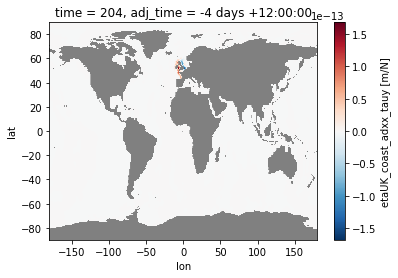

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1026: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


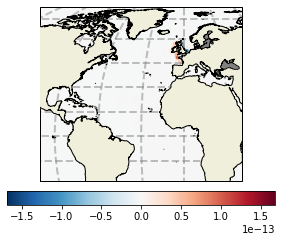

In [25]:
ll.etaUK_coast_adxx_tauy.isel(time=204).plot()
mapper(ds.etaUK_coast_adxx_tauy.isel(time=204), cmap='RdBu_r')

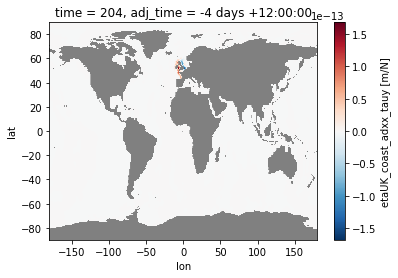

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1026: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


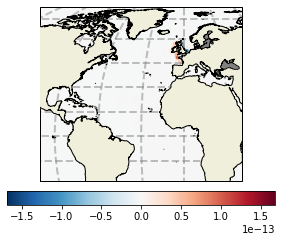

In [26]:
ll.etaUK_coast_adxx_tauy.isel(time=204).plot()
mapper(ds.etaUK_coast_adxx_tauy.isel(time=204), cmap='RdBu_r')

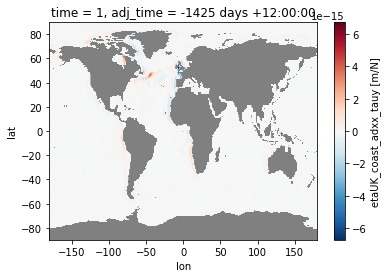

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1026: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


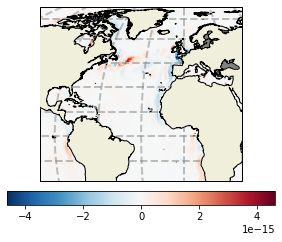

In [27]:
ll.etaUK_coast_adxx_tauy.isel(time=1).plot()
mapper(ds.etaUK_coast_adxx_tauy.isel(time=1), cmap='RdBu_r')

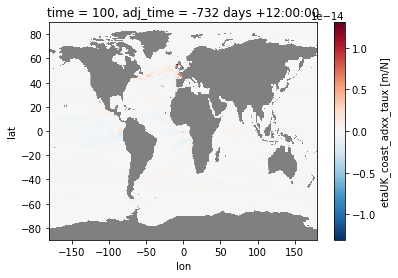

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:1026: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


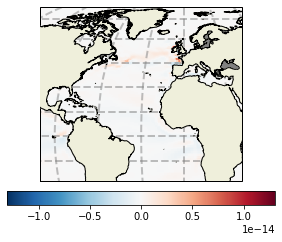

In [28]:
ll.etaUK_coast_adxx_taux.isel(time=100).plot()
mapper(ds.etaUK_coast_adxx_taux.isel(time=100), cmap='RdBu_r')

In [29]:
ll.attrs = ds.attrs

In [30]:
ll.etaUK_coast_adxx_taux.description

'Sensitivity of March UK sea level anomaly to changes in zonal wind stress at decreasing lead times'

In [31]:
ll.to_netcdf('datasets/monthlyEtaUK_weeklySens_latlon.nc')